## Table of Contents
1. Data preparation
2. Feature engineering
3. Model
4. Results evaluation
5. Other things you could try
6. Deep Learning
7. Word to Vector
8. Clustering
9. High-dimension Visualization



### Necessary Library Requirements:

#### Same as Lab1:
- [Jupyter](http://jupyter.org/) (Strongly recommended but not required)
    - Install via `pip3 install jupyter` and use `jupyter notebook` in terminal to run
- [Scikit Learn](http://scikit-learn.org/stable/index.html)
    - Install via `pip3 sklearn` from a terminal
- [Pandas](http://pandas.pydata.org/)
    - Install via `pip3 install pandas` from a terminal
- [Numpy](http://www.numpy.org/)
    - Install via `pip3 install numpy` from a terminal
- [Matplotlib](https://matplotlib.org/)
    - Install via `pip3 maplotlib` from a terminal
- [Plotly](https://plot.ly/)
    - Install via `pip3 install plotly` from a terminal
- [Seaborn](https://seaborn.pydata.org/)
    - Install and signup for `seaborn`
- [NLTK](http://www.nltk.org/)
    - Install via `pip3 install nltk` from a terminal

#### New Libraries to install:
- [Gensim](https://pypi.org/project/gensim/)
    - Install via `pip3 install gensim`

- [tensorflow](https://www.tensorflow.org/)
    - Install via `pip3 install tensorflow`
    - Also install `pip3 install tensorflow-hub`

- [Keras](https://keras.io/)
    - Install via `pip3 install keras`

Name: tensorflow-gpum
Version: 1.14.0

---
## Introduction

**Dataset:** [SemEval 2017 Task](https://competitions.codalab.org/competitions/16380)

**Task:** Classify text data into 4 different emotions using word embedding and other deep information retrieval approaches.

![pic0](pics/pic0.png)

## 0 load the basic module in advance

In [24]:
# Load the basic Python modules 2023/10/21
import IPython.display
import json
import pandas as pd
import seaborn as sns
import squarify

import missingno as msno
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import numpy as np
from matplotlib import pyplot as plt
import datetime

# D3 modules
from IPython.core.display import display, HTML, Javascript
from string import Template

---
## 1. Data Preparation

Before beggining the lab, please make sure to download the [Google News Dataset](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit) and place it in a folder named "GoogleNews" in the same directory as this file.

## 1.1 Load data

We start by loading the csv files into a single pandas dataframe for training and one for testing.

In [6]:
import pandas as pd

### training data
anger_train = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

In [7]:
# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [8]:
### testing data
anger_test = pd.read_csv("data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [9]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [10]:
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (3613, 4)
Shape of Testing df:  (347, 4)


In [42]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3613 entries, 1704 to 1748
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              3613 non-null   int64  
 1   text            3613 non-null   object 
 2   emotion         3613 non-null   object 
 3   intensity       3613 non-null   float64
 4   text_tokenized  3613 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 169.4+ KB


In [43]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347 entries, 123 to 185
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         347 non-null    int64  
 1   text       347 non-null    object 
 2   emotion    347 non-null    object 
 3   intensity  347 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 13.6+ KB


In [11]:
test_df.head()

,id,text,emotion,intensity
202,30831,Google caffeine-an sprightly lengthening into ...,joy,0.200
230,30859,incredible that anthony weiner has been caught...,joy,0.380
38,10895,For the first time in my madden career I just ...,anger,0.271
210,30839,Good #CX most often doesn't require all that m...,joy,0.583
231,30860,@len_snart Mick nods. 'I would like that.' He ...,joy,0.620


---
### ** >>> Exercise 1 (Take home): **  
Plot word frequency for Top 30 words in both train and test dataset. (Hint: refer to DM lab 1)


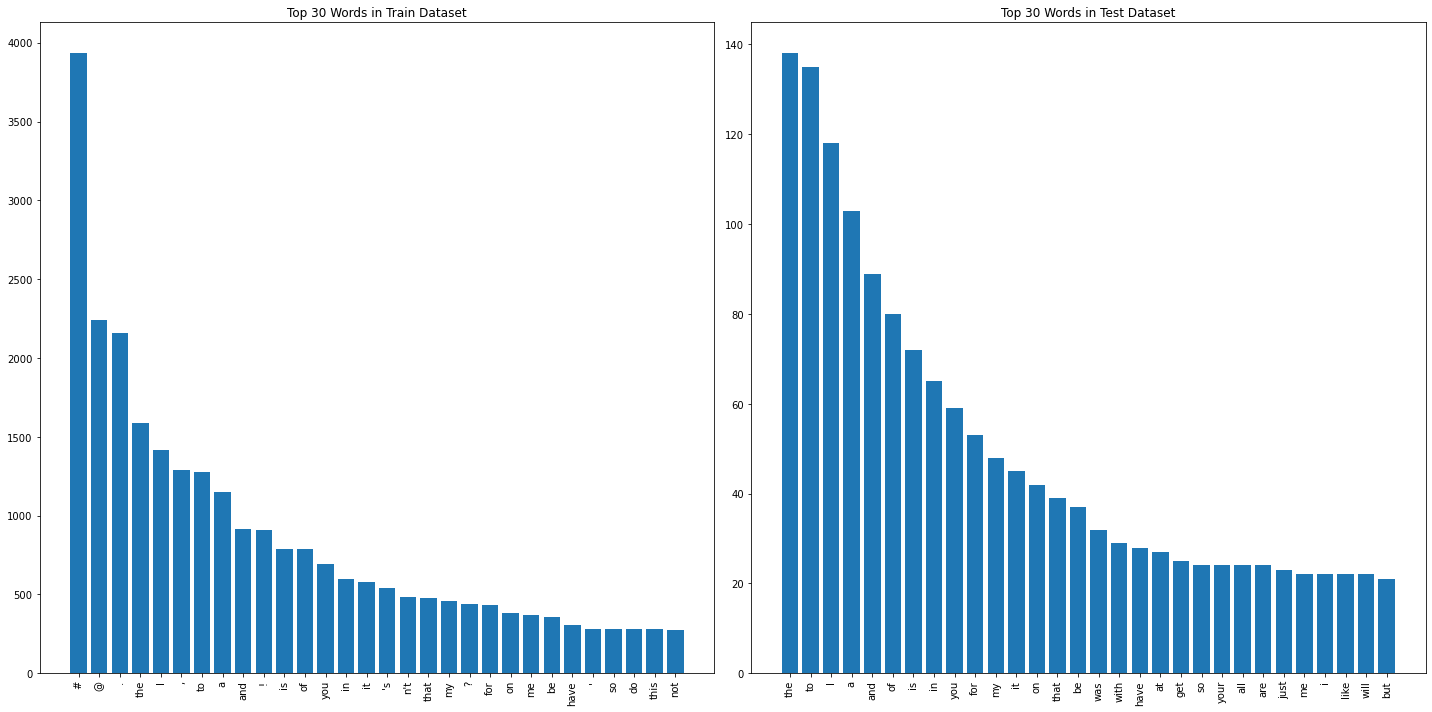

In [45]:
# Answer here
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Sample data (replace these with your actual DataFrame)
#train_df = pd.DataFrame(...)  # Replace with your train_df data
#test_df = pd.DataFrame(...)   # Replace with your test_df data

# For train_df, assuming 'text_tokenized' contains a list of tokens
train_word_counts = Counter(word for row in train_df['text_tokenized'] for word in row)

# For test_df, tokenize 'text' column (assuming simple whitespace tokenization)
test_word_counts = Counter(word for row in test_df['text'].str.split() for word in row)

# Get the top 30 words in each dataset
top_30_train = train_word_counts.most_common(30)
top_30_test = test_word_counts.most_common(30)

# Unzipping the words and their counts for plotting
train_words, train_counts = zip(*top_30_train)
test_words, test_counts = zip(*top_30_test)

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plotting for train_df
axes[0].bar(train_words, train_counts)
axes[0].set_title('Top 30 Words in Train Dataset')
axes[0].set_xticklabels(train_words, rotation='vertical')

# Plotting for test_df
axes[1].bar(test_words, test_counts)
axes[1].set_title('Top 30 Words in Test Dataset')
axes[1].set_xticklabels(test_words, rotation='vertical')

# Display the plot
plt.tight_layout()
plt.show()


---
### 1.2 Save data

We will save our data in Pickle format. The pickle module implements binary protocols for serializing and de-serializing a Python object structure.   
  
Some advantages for using pickle structure:  
* Because it stores the attribute type, it's more convenient for cross-platform use.  
* When your data is huge, it could use less space to store also consume less loading time.   

In [7]:
## save to pickle file
train_df.to_pickle("train_df.pkl") 
test_df.to_pickle("test_df.pkl")

In [1]:
import pandas as pd

## load a pickle file
train_df = pd.read_pickle("./data/train_df.pkl")
test_df = pd.read_pickle("./data/test_df.pkl")

For more information: https://reurl.cc/0Dzqx

---
### 1.3 Exploratory data analysis (EDA)

Again, before getting our hands dirty, we need to explore a little bit and understand the data we're dealing with.

In [2]:
train_df['emotion'].unique()

array(['fear', 'sadness', 'anger', 'joy'], dtype=object)

In [4]:
# group to find distribution
train_df.groupby(['emotion']).count()['text']

emotion
anger       857
fear       1147
joy         823
sadness     786
Name: text, dtype: int64

In [28]:
train_df

,id,text,emotion,intensity
1704,20847,@realDonaldTrump @KellyannePolls New campaign ...,fear,0.354
1152,20295,We in our own country are so divided in our ap...,fear,0.625
1038,20181,@twlldun @bbcquestiontime @JacobReesMogg @leic...,fear,0.696
3497,40670,#PeopleLikeMeBecause of some unknown reason bu...,sadness,0.278
1940,21083,@BigDaddyx47 awe I'm sorry! I have 2 dogs 3 ca...,fear,0.188
...,...,...,...,...
636,10636,New madden kicking 🚮,anger,0.396
1095,20238,wow if i need to start over on SIF im prob gon...,fear,0.667
2328,30324,"— to reveal a broad smile. \n\n'Yeah, it's nic...",joy,0.542
2430,30426,Relive Vegas' heyday with Rat Pack tribute,joy,0.480


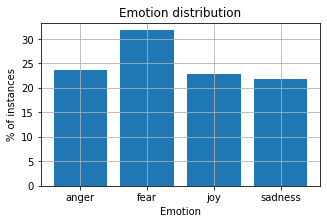

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

---

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# build analyzers (bag-of-words)
BOW_vectorizer = CountVectorizer() 

# 1. Learn a vocabulary dictionary of all tokens in the raw documents.
BOW_vectorizer.fit(train_df['text'])

# 2. Transform documents to document-term matrix.
train_data_BOW_features = BOW_vectorizer.transform(train_df['text'])
test_data_BOW_features = BOW_vectorizer.transform(test_df['text'])

# check the result
train_data_BOW_features

type(train_data_BOW_features)

# add .toarray() to show
train_data_BOW_features.toarray()

# check the dimension
train_data_BOW_features.shape

# observe some feature names
feature_names = BOW_vectorizer.get_feature_names_out()
feature_names[100:110]

## 2. Feature engineering
### Using Bag of Words
Using scikit-learn ```CountVectorizer``` perform word frequency and use these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
# build analyzers (bag-of-words)
BOW_vectorizer = CountVectorizer() 

In [7]:
# 1. Learn a vocabulary dictionary of all tokens in the raw documents.
BOW_vectorizer.fit(train_df['text'])

# 2. Transform documents to document-term matrix.
train_data_BOW_features = BOW_vectorizer.transform(train_df['text'])
test_data_BOW_features = BOW_vectorizer.transform(test_df['text'])

In [8]:
# check the result
train_data_BOW_features

<3613x10115 sparse matrix of type '<class 'numpy.int64'>'
	with 51467 stored elements in Compressed Sparse Row format>

In [9]:
type(train_data_BOW_features)

scipy.sparse.csr.csr_matrix

In [10]:
# add .toarray() to show
train_data_BOW_features.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [11]:
# check the dimension
train_data_BOW_features.shape

(3613, 10115)

In [12]:
# observe some feature names
feature_names = BOW_vectorizer.get_feature_names_out()
feature_names[100:110]

array(['2k17', '2much', '2nd', '30', '300', '301', '30am', '30pm', '30s',
       '31'], dtype=object)

The embedding is done. We can technically feed this into our model. However, depending on the embedding technique you use and your model, your accuracy might not be as high, because:

* curse of dimensionality  (we have 10,115 dimension now)
* some important features are ignored (for example, some models using emoticons yeld better performance than counterparts)

In [14]:
"😂" in feature_names

False

Let's try using another tokenizer below.

In [13]:
import nltk

# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
BOW_500.fit(train_df['text'])

train_data_BOW_features_500 = BOW_500.transform(train_df['text'])

## check dimension
train_data_BOW_features_500.shape

D:\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


(3613, 500)

In [16]:
train_data_BOW_features_500.toarray()

array([[0, 3, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [17]:
# observe some feature names
feature_names_500 = BOW_500.get_feature_names_out()
feature_names_500[100:110]

array(['change', 'cheer', 'cheerful', 'cheering', 'cheery', 'class',
       'come', 'comes', 'could', 'country'], dtype=object)

In [18]:
"😂" in feature_names_500

True

---
### ** >>> Exercise 2 (Take home): **  
Generate an embedding using the TF-IDF vectorizer instead of th BOW one with 1000 features and show the feature names for features [100:110].

In [46]:
# Answer here
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer with a maximum of 1000 features
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# 1. Learn a vocabulary dictionary of all tokens in the raw documents.
tfidf_vectorizer.fit(train_df['text'])

# 2. Transform documents to a document-term matrix.
train_data_tfidf_features = tfidf_vectorizer.transform(train_df['text'])
test_data_tfidf_features = tfidf_vectorizer.transform(test_df['text'])

# Check the result
print(train_data_tfidf_features)

# Check the type
print(type(train_data_tfidf_features))

# Convert to array and display
print(train_data_tfidf_features.toarray())

# Check the dimension
print(train_data_tfidf_features.shape)

# Observe some feature names
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
print(feature_names_tfidf[100:110])


  (0, 995)	0.17567352889333207
  (0, 948)	0.2531571914381469
  (0, 696)	0.3829527423653722
  (0, 587)	0.31894463908648896
  (0, 477)	0.28080801787808546
  (0, 433)	0.42645702733860313
  (0, 134)	0.4390518057146898
  (0, 127)	0.22087997693295242
  (0, 53)	0.24105622690910614
  (0, 34)	0.3103070512704472
  (1, 939)	0.34944632520890145
  (1, 842)	0.4637690560022666
  (1, 781)	0.301247770570476
  (1, 630)	0.247871787221754
  (1, 625)	0.4022365259487296
  (1, 438)	0.24771106764275633
  (1, 429)	0.19022266581355796
  (1, 293)	0.28084599142091504
  (1, 182)	0.2781939306075897
  (1, 180)	0.23464832733215
  (1, 53)	0.16801428826801887
  (1, 42)	0.10826012831720254
  (2, 850)	0.26619409223627355
  (2, 608)	0.36604133154849033
  (2, 596)	0.23011276649029097
  :	:
  (3609, 583)	0.3037910755169785
  (3609, 466)	0.2174573471237263
  (3609, 435)	0.3248127758742646
  (3609, 434)	0.23801462771296167
  (3609, 356)	0.36317555177996674
  (3609, 212)	0.41072348910986617
  (3610, 988)	0.35140518355581485
  

---
## 3. Model
### 3.1 Decision Trees
Using scikit-learn ```DecisionTreeClassifier``` performs word frequency and uses these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

In [14]:
from sklearn.tree import DecisionTreeClassifier

# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## take a look at data dimension is a good habit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


In [15]:
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1)

## training!
DT_model = DT_model.fit(X_train, y_train)

## predict!
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)

## so we get the pred result
y_test_pred[:10]

array(['joy', 'anger', 'joy', 'fear', 'joy', 'sadness', 'joy', 'joy',
       'sadness', 'joy'], dtype=object)

---
## 4. Results Evaluation

Now we will check the results of our model's performance

In [21]:
## accuracy
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))


training accuracy: 0.99
testing accuracy: 0.64


In [22]:
## precision, recall, f1-score,
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

       anger       0.65      0.70      0.67        84
        fear       0.66      0.62      0.64       110
         joy       0.61      0.65      0.63        79
     sadness       0.65      0.61      0.63        74

    accuracy                           0.64       347
   macro avg       0.64      0.64      0.64       347
weighted avg       0.64      0.64      0.64       347



In [23]:
## check by confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 
print(cm)

[[59 11 12  2]
 [18 68 11 13]
 [ 6 13 51  9]
 [ 8 11 10 45]]


In [24]:
# Funciton for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

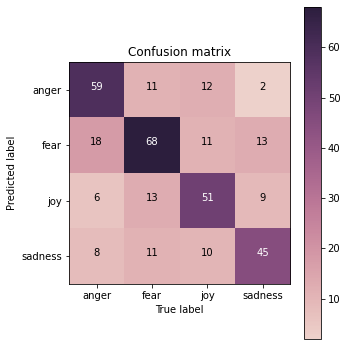

In [25]:
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

---
### ** >>> Exercise 3 (Take home): **  
Can you interpret the results above? What do they mean?

In [ ]:
# Answer here (2023/12/2)
# Test dataset has 347 entries.Take the 'anger' emoition for example, there are 91 entries of 'anger' emoition. 
# But for the predicted results, 59 entries is predicted to anger, 18 to fear, 6 to joy and 8 to sadness.

In [40]:
# Answer here
# 1. The testing using the Naive Bayes model is as below code.
# 2. For f1 score of 'fear' and 'joy', Naive Bayes model is better than DecisionTree model.
# 3. For accuracy ,Naive Bayes model with score 0.69 is also better than DecisionTree model 0.64.

In [36]:
import numpy as np
# >>> rng = np.random.RandomState(1)
# >>> X = rng.randint(5, size=(6, 100))
# >>> y = np.array([1, 2, 3, 4, 5, 6])
from sklearn.naive_bayes import MultinomialNB
X=X_train
y=y_train
#clf = MultinomialNB(force_alpha=True)
clf = MultinomialNB()
clf.fit(X, y)
#MultinomialNB(force_alpha=True)
#print(clf.predict(X[2:3]))
#[3]

MultinomialNB()

In [38]:
y_pred_clf=clf.predict(X_test)

In [39]:
## precision, recall, f1-score,
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_pred_clf))

              precision    recall  f1-score   support

       anger       0.65      0.65      0.65        84
        fear       0.72      0.77      0.75       110
         joy       0.76      0.70      0.73        79
     sadness       0.63      0.62      0.63        74

    accuracy                           0.69       347
   macro avg       0.69      0.69      0.69       347
weighted avg       0.70      0.69      0.69       347



---
### ** >>> Exercise 5 (Take home): **  

How do the results from the Naive Bayes model and the Decision Tree model compare? How do you interpret these differences? Use the theoretical background covered in class to try and explain these differences.

# Answer here優缺點比較
Precision: This measures the accuracy of the positive predictions. Higher precision means fewer false positives.

For "anger", both models have the same precision (0.65).
For "fear" and "joy", Naive Bayes performs better (0.72 and 0.76 respectively) compared to Decision Trees (0.66 and 0.61).
For "sadness", the precision is almost the same, slightly higher in Decision Trees (0.65 vs. 0.63).
Recall: This measures the ability of the model to find all the positive instances. Higher recall means fewer false negatives.

For "anger", both models have similar recall (0.65 for Naive Bayes, 0.70 for Decision Trees).
Naive Bayes has higher recall for "fear" and "joy" (0.77 and 0.70) compared to Decision Trees (0.62 and 0.65).
For "sadness", recall is almost the same for both models (0.62 for Naive Bayes, 0.61 for Decision Trees).
F1-score: This is the harmonic mean of precision and recall. A higher F1-score indicates a balance between precision and recall.

For "anger" and "sadness", the F1-scores are comparable between the two models.
Naive Bayes shows higher F1-scores for "fear" and "joy".
Accuracy: This measures the overall correctness of the model.

Naive Bayes shows higher overall accuracy (0.69) compared to Decision Trees (0.64).
Interpreting the Differences:

Naive Bayes generally performs better, especially in terms of accuracy and F1-score. This might be due to its statistical approach to classification, which can be particularly effective for text classification.
Decision Trees, which split data based on feature values, might be less effective for the nuances in text data, leading to slightly lower performance metrics.
The relatively close performance of both models suggests that the choice of model could depend on the specific use case and the importance of different metrics (e.g., precision vs. recall).
Theoretical Background:

Naive Bayes assumes independence among predictors. In text classification, even if this assumption is often violated (words in sentences are often dependent), the model can still perform well.
Decision Trees make no assumption about the distribution of data. They may be less effective if the decision boundaries are not well-defined or if the data is high-dimensional (as is often the case with text data).
In summary, the differences in performance can be attributed to the underlying assumptions and mechanisms of these models, with Naive Bayes potentially being more suited for the complexities of text classification.

---

## 5. Other things you can try

Thus, there are several things you can try that will affect your results. In order to yield better results, you can experiment by: 
- Trying different features (Feature engineering)e.g Word2Vec, PCA, LDA, FastText, Clustering
- Trying different models
- Analyzing your results and interpret them to improve your feature engineering/model building process
- Iterate through the steps above until finding a satisfying result

Remember that you should also consider the task at hand and the model you'll feed the data to. 

---
## 6. Deep Learning

We use [Keras](https://keras.io/) to be our deep learning framwork, and follow the [Model (functional API)](https://keras.io/models/model/) to build a Deep Neural Network (DNN) model. Keras runs with Tensorflow in the backend. It's a nice abstraction to start working with NN models. 

Because Deep Learning is a 1-semester course, we can't talk about each detail about it in the lab session. Here, we only provide a simple template about how to build & run a DL model successfully. You can follow this template to design your model.

We will begin by building a fully connected network, which looks like this:

![Fully Connected Network](pics/pic1.png)

(source: https://github.com/drewnoff/spark-notebook-ml-labs/tree/master/labs/DLFramework)


### 6.1 Prepare data (X, y)

In [16]:
import keras

# standardize name (X, y) 
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## check dimension is a good habbit 
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


### 6.2 Deal with categorical label (y)

Rather than put your label `train_df['emotion']` directly into a model, we have to process these categorical (or say nominal) label by ourselves. 

Here, we use the basic method [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) to transform our categorical  labels to numerical ones.


In [17]:
## deal with label (string -> one-hot)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)


check label:  ['anger' 'fear' 'joy' 'sadness']

## Before convert
y_train[0:4]:
 1704       fear
1152       fear
1038       fear
3497    sadness
Name: emotion, dtype: object

y_train.shape:  (3613,)
y_test.shape:  (347,)


## After convert
y_train[0:4]:
 [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]

y_train.shape:  (3613, 4)
y_test.shape:  (347, 4)


### 6.3 Build model

In [18]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  500
output_shape:  4


![Imgur](pics/pic2.png)

In [19]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense (Dense)               (None, 64)                32064     
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 re_lu_1 (ReLU)              (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
 softmax (Softmax)           (None, 4)                 0     

### 6.4 Train

In [20]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('logs/training_log.csv')

# training setting
epochs = 25
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

Epoch 1/25
113/113 [==============================] - 2s 5ms/step - loss: 1.3412 - accuracy: 0.3606 - val_loss: 1.2947 - val_accuracy: 0.4265
Epoch 2/25
113/113 [==============================] - 0s 3ms/step - loss: 1.0274 - accuracy: 0.6355 - val_loss: 0.9536 - val_accuracy: 0.6427
Epoch 3/25
113/113 [==============================] - 0s 3ms/step - loss: 0.6114 - accuracy: 0.7833 - val_loss: 0.7936 - val_accuracy: 0.6974
Epoch 4/25
113/113 [==============================] - 0s 2ms/step - loss: 0.4278 - accuracy: 0.8409 - val_loss: 0.7711 - val_accuracy: 0.6945
Epoch 5/25
113/113 [==============================] - 0s 3ms/step - loss: 0.3398 - accuracy: 0.8785 - val_loss: 0.8170 - val_accuracy: 0.6916
Epoch 6/25
113/113 [==============================] - 0s 3ms/step - loss: 0.2775 - accuracy: 0.9078 - val_loss: 0.8739 - val_accuracy: 0.7003
Epoch 7/25
113/113 [==============================] - 0s 3ms/step - loss: 0.2261 - accuracy: 0.9255 - val_loss: 0.9236 - val_accuracy: 0.6859
Epoch 

### 6.5 Predict on testing data

In [21]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

3/3 [==============================] - 0s 3ms/step


array([[6.4814824e-01, 3.5118884e-01, 6.1897095e-04, 4.3931039e-05],
       [3.8159654e-02, 2.6175785e-01, 2.6603198e-05, 7.0005590e-01],
       [1.9863568e-05, 2.2709541e-05, 9.9991488e-01, 4.2497028e-05],
       [1.0657503e-04, 9.9452990e-01, 1.7924699e-06, 5.3617922e-03],
       [6.6950649e-04, 1.8595244e-07, 9.9929380e-01, 3.6561833e-05]],
      dtype=float32)

In [25]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

array(['anger', 'sadness', 'joy', 'fear', 'joy'], dtype=object)

In [26]:
from sklearn.metrics import accuracy_score

print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

testing accuracy: 0.67


In [27]:
#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("logs/training_log.csv")
training_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.360642,1.341246,0.426513,1.294704
1,1,0.635483,1.027370,0.642651,0.953611
2,2,0.783283,0.611361,0.697406,0.793555
3,3,0.840852,0.427757,0.694524,0.771076
4,4,0.878494,0.339836,0.691643,0.816951
5,5,0.907833,0.277491,0.700288,0.873928
6,6,0.925547,0.226119,0.685879,0.923646
7,7,0.941600,0.189033,0.682997,0.964507
8,8,0.952671,0.162361,0.688761,1.061017
9,9,0.957376,0.139245,0.685879,1.084646


---
### ** >>> Exercise 6 (Take home): **  

Plot the Training and Validation Accuracy and Loss (different plots), just like the images below.(Note: the pictures below are an example from a different model). How to interpret the graphs you got? How are they related to the concept of overfitting/underfitting covered in class?
<table><tr>
    <td><img src="pics/pic3.png" style="width: 300px;"/> </td>
    <td><img src="pics/pic4.png" style="width: 300px;"/> </td>
</tr></table>

In [ ]:
# Answer here


---

### Note

If you don't have a GPU (level is higher than GTX 1060) or you are not good at setting lots of things about computer, we recommend you to use the [kaggle kernel](https://www.kaggle.com/kernels) to do deep learning model training. They have already installed all the librarys and provided free GPU for you to use.

Note however that you will only be able to run a kernel for 6 hours. After 6 hours of inactivity, your Kaggle kernel will shut down (meaning if your model takes more than 6 hours to train, you can't train it at once).


### More Information for your reference

* Keras document: https://keras.io/
* Keras GitHub example: https://github.com/keras-team/keras/tree/master/examples
* CS229: Machine Learning: http://cs229.stanford.edu/syllabus.html
* Deep Learning cheatsheet: https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning
* If you want to try TensorFlow or PyTorch: https://pytorch.org/tutorials/
https://www.tensorflow.org/tutorials/quickstart/beginner

---
## 7. Word2Vector

We will introduce how to use `gensim` to train your word2vec model and how to load a pre-trained model.

https://radimrehurek.com/gensim/index.html

### 7.1 Prepare training corpus

In [28]:
## check library
import gensim

## ignore warnings
import warnings
warnings.filterwarnings('ignore')

# # if you want to see the training messages, you can use it
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## the input type
train_df['text_tokenized'] = train_df['text'].apply(lambda x: nltk.word_tokenize(x))
train_df[['id', 'text', 'text_tokenized']].head()

,id,text,text_tokenized
1704,20847,@realDonaldTrump @KellyannePolls New campaign ...,"[@, realDonaldTrump, @, KellyannePolls, New, c..."
1152,20295,We in our own country are so divided in our ap...,"[We, in, our, own, country, are, so, divided, ..."
1038,20181,@twlldun @bbcquestiontime @JacobReesMogg @leic...,"[@, twlldun, @, bbcquestiontime, @, JacobReesM..."
3497,40670,#PeopleLikeMeBecause of some unknown reason bu...,"[#, PeopleLikeMeBecause, of, some, unknown, re..."
1940,21083,@BigDaddyx47 awe I'm sorry! I have 2 dogs 3 ca...,"[@, BigDaddyx47, awe, I, 'm, sorry, !, I, have..."


In [29]:
## create the training corpus
training_corpus = train_df['text_tokenized'].values
training_corpus[:3]

array([list(['@', 'realDonaldTrump', '@', 'KellyannePolls', 'New', 'campaign', 'slogan', 'idea', '...', "'", 'I', 'know', 'you', 'are', 'but', 'what', 'am', 'I', '?', "'", '#', 'Trump2016', '#', 'yourefired', '#', 'deflect']),
       list(['We', 'in', 'our', 'own', 'country', 'are', 'so', 'divided', 'in', 'our', 'approach', 'so', 'how', 'could', 'we', 'fight', '#', 'terrorism', 'and', '#', 'pakistani', 'terrorism', '#', 'MartyrsNotBeggars']),
       list(['@', 'twlldun', '@', 'bbcquestiontime', '@', 'JacobReesMogg', '@', 'leicesterliz', '@', 'normanlamb', '@', 'CarolineLucas', '@', 'JuliaHB1', 'Oh', 'god', ',', 'not', 'Brewer', 'again', '.', 'The', 'horror', ',', 'the', 'horror'])],
      dtype=object)

### 7.2 Training our model

You can try to train your own model. More details: https://radimrehurek.com/gensim/models/word2vec.html

In [30]:
from gensim.models import Word2Vec

## setting
vector_dim = 100
window_size = 5
min_count = 1
training_epochs = 20

## model
word2vec_model = Word2Vec(sentences=training_corpus, 
                          vector_size=vector_dim, window=window_size, 
                          min_count=min_count, epochs=training_epochs)

![Imgur](https://i.imgur.com/Fca3MCs.png)

### 7.3 Generating word vector (embeddings)

In [31]:
# get the corresponding vector of a word
word_vec = word2vec_model.wv['happy']
word_vec

array([ 0.5056117 ,  0.22560452, -0.01659051,  0.19569995, -0.12576766,
       -0.6787057 ,  0.43333897,  1.172142  , -0.3942537 , -0.43720046,
       -0.8445446 , -0.45382044, -0.5524278 , -0.13832647,  0.2981775 ,
       -0.47502583,  0.3083535 , -0.8502216 , -0.24515946, -1.255803  ,
        0.80118746,  0.6885382 ,  1.051411  ,  0.04768629,  0.33015388,
        0.00951385, -0.51292187,  0.22443172, -0.5696387 ,  0.20742156,
       -0.12127503,  0.00497321,  0.5883382 , -0.8536729 ,  0.16178806,
        0.87393504,  0.12524213, -0.69824225, -0.8855187 , -0.27941725,
        0.00562972,  0.12921792, -0.10492034,  0.11256392,  0.7333057 ,
       -0.33481154, -0.76570725,  0.00533079,  0.9707031 ,  0.37601104,
        0.2397088 , -0.5418997 , -0.002558  , -0.02309746, -0.69888806,
       -0.256352  , -0.19247976, -0.14810638, -0.10555707, -0.00255226,
        0.05794791, -0.13580957,  0.66888386,  0.07767083, -0.5537654 ,
        0.6977137 ,  0.32145593,  0.5927188 , -1.4068851 ,  0.81

In [32]:
# Get the most similar words
word = 'happy'
topn = 10
word2vec_model.wv.most_similar(word, topn=topn)

[('Be', 0.9217737913131714),
 ('smile', 0.920883297920227),
 ('right', 0.9198489189147949),
 ('birthday', 0.9177707433700562),
 ('.\\nA', 0.913675844669342),
 ('cry', 0.912006676197052),
 ('cats', 0.9119700789451599),
 ('farm365', 0.9101703763008118),
 ('^_^', 0.9091914296150208),
 ('establishment', 0.9091620445251465)]

### 7.4 Using a pre-trained w2v model

Instead of training your own model ,you can use a model that has already been trained. Here, we see 2 ways of doing that:


#### (1) Download model by yourself

source: [GoogleNews-vectors-negative300](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/view?resourcekey=0-wjGZdNAUop6WykTtMip30g)

more details: https://radimrehurek.com/gensim/models/keyedvectors.html

In [33]:
from gensim.models import KeyedVectors

## Note: this model is very huge, this will take some time ...
model_path = "./GoogleNews-vectors-negative300.bin.gz"

#model_path = "./GoogleNews/GoogleNews-vectors-negative300.bin.gz"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print('load ok')

w2v_google_model.most_similar('happy', topn=10)

load ok


[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

#### (2) Using gensim api

Other pretrained models are available here: https://github.com/RaRe-Technologies/gensim-data

In [42]:
import gensim.downloader as api

## If you see `SSL: CERTIFICATE_VERIFY_FAILED` error, use this:
import ssl
import urllib.request
ssl._create_default_https_context = ssl._create_unverified_context

glove_twitter_25_model = api.load("glove-twitter-25")
print('load ok')

glove_twitter_25_model.most_similar('happy', topn=10)

[==================================================] 100.0% 104.8/104.8MB downloaded
load ok


[('birthday', 0.9577818512916565),
 ('thank', 0.937666654586792),
 ('welcome', 0.93361496925354),
 ('love', 0.917618453502655),
 ('miss', 0.9164499640464783),
 ('hello', 0.9158352017402649),
 ('thanks', 0.9150084853172302),
 ('merry', 0.9053248167037964),
 ('bless', 0.902732253074646),
 ('wish', 0.9013165235519409)]

### 7.5 king + woman - man = ?

Let's run one of the most famous examples for Word2Vec and compute the similarity between these 3 words:

In [34]:
w2v_google_model.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593831062317),
 ('monarchy', 0.5087411999702454)]

---
### ** >>> Exercise 7 (Take home): **  

Now, we have the word vectors, but our input data is a sequence of words (or say sentence). 
How can we utilize these "word" vectors to represent the sentence data and train our model?


In [ ]:
# Answer here


### 8. Clustering: k-means

Here we introduce how to use `sklearn` to do the basic **unsupervised learning** approach, k-means.    

more details: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


#### Basic concept

![Image](https://i.imgur.com/PEdUf54.png)

(img source: https://towardsdatascience.com/k-means-clustering-identifying-f-r-i-e-n-d-s-in-the-world-of-strangers-695537505d)

In [35]:
# clustering target
target_list = ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']
print('target words: ', target_list)

# convert to word vector
X = [word2vec_model.wv[word] for word in target_list]
# 1106 : to here

target words:  ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']


In [36]:
from sklearn.cluster import KMeans

# we have to decide how many cluster (k) we want
k = 2

# k-means model
kmeans_model = KMeans(n_clusters=k)
kmeans_model.fit(X)

# cluster result
cluster_result = kmeans_model.labels_

# show
for i in range(len(target_list)):
    print('word: {} \t cluster: {}'.format(target_list[i], cluster_result[i]))

word: happy 	 cluster: 0
word: fear 	 cluster: 0
word: angry 	 cluster: 0
word: car 	 cluster: 1
word: teacher 	 cluster: 1
word: computer 	 cluster: 1


![Imgur](pics/pic6.png)

In [37]:
#check cluster membership
word = 'student'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([1])

In [38]:
#check cluster membership
word = 'sad'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([0])


## 9. High-dimension Visualization: t-SNE

No matter if you use the Bag-of-words, TF-IDF, or Word2Vec, it's very hard to see the embedding result, because the dimension is larger than 3.  

In Lab 1, we already talked about PCA. We can use PCA to reduce the dimension of our data, then visualize it. However, if you dig deeper into the result, you'd find it is insufficient.

Our aim will be to create a visualization similar to the one below:

![Image](pics/pic7.png)
source: https://www.fabian-keller.de/research/high-dimensional-data-visualization 

Here we would like to introduce another visualization method called t-SNE.  
http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html 

### 9.1 Prepare visualizing target

Let's prepare data lists like:
- happy words
- angry words
- data words
- mining words

In [39]:
word_list = ['happy', 'angry', 'data', 'mining']

topn = 5
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]        
data_words = ['data'] + [word_ for word_, sim_ in w2v_google_model.most_similar('data', topn=topn)]        
mining_words = ['mining'] + [word_ for word_, sim_ in w2v_google_model.most_similar('mining', topn=topn)]        

print('happy_words: ', happy_words)
print('angry_words: ', angry_words)
print('data_words: ', data_words)
print('mining_words: ', mining_words)

target_words = happy_words + angry_words + data_words + mining_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

happy_words:  ['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled']
angry_words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed']
data_words:  ['data', 'Data', 'datasets', 'dataset', 'databases', 'statistics']
mining_words:  ['mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

target words: 
['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'data', 'Data', 'datasets', 'dataset', 'databases', 'statistics', 'mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

color list:
['b', 'b', 'b', 'b', 'b', 'b', 'g', 'g', 'g', 'g', 'g', 'g', 'r', 'r', 'r', 'r', 'r', 'r', 'y', 'y', 'y', 'y', 'y', 'y']


### 9.2 Plot using t-SNE (2-dimension)

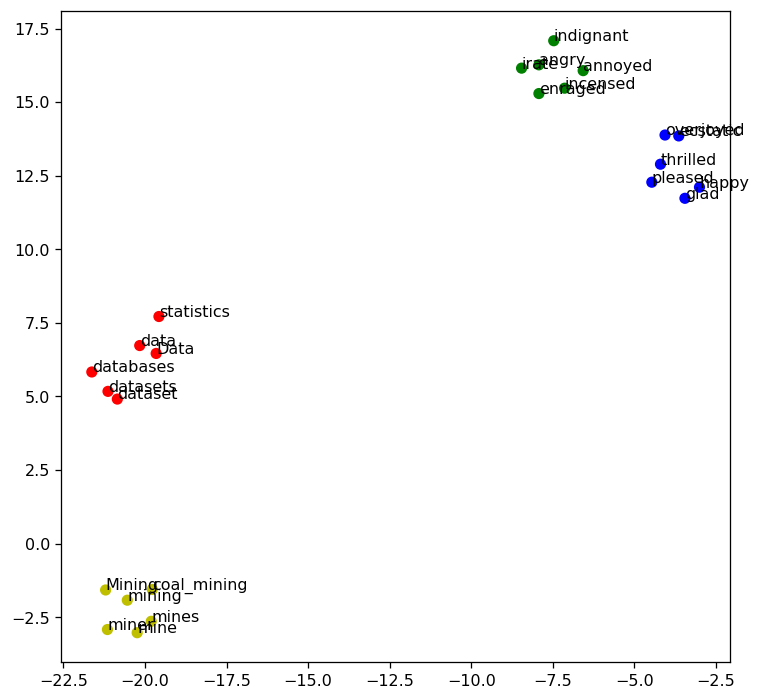

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

---
### ** >>> Exercise 8 (Take home): **  

Generate a t-SNE visualization to show the 15 words most related to the words "angry", "happy", "sad", "fear" (60 words total).

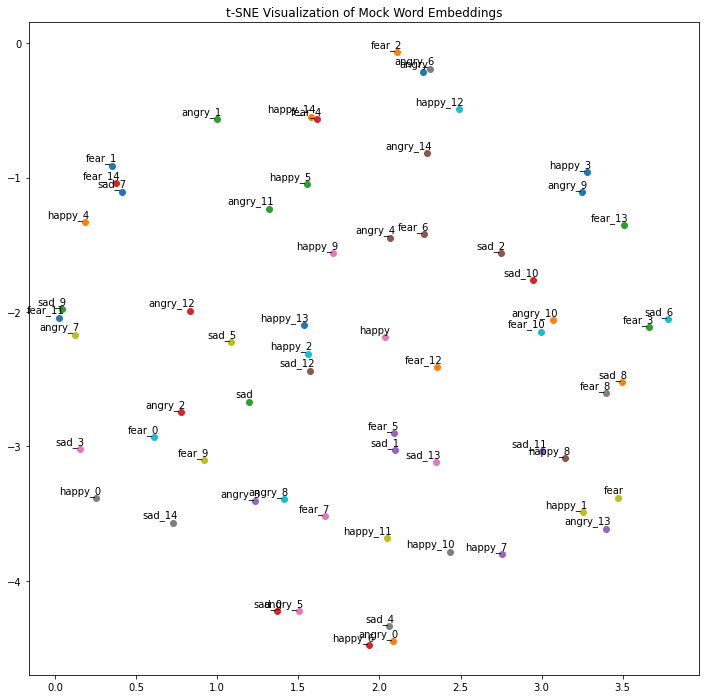

In [41]:
# Answer here
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Setting a seed for reproducibility
np.random.seed(28)

# Define the number of target words and similar words per target word
num_words = 4  # "angry", "happy", "sad", "fear"
num_similar_per_word = 15
total_words = num_words * (num_similar_per_word + 1)  # Including the target words

# Generate random vectors to represent word embeddings
word_vectors = np.random.normal(size=(total_words, 300))

# Initialize and fit the t-SNE model
tsne_model = TSNE(n_components=2, metric='cosine', random_state=28)
X_tsne = tsne_model.fit_transform(word_vectors)

# Create labels for the mock data
word_labels = ["angry"] + [f"angry_{i}" for i in range(num_similar_per_word)] + \
              ["happy"] + [f"happy_{i}" for i in range(num_similar_per_word)] + \
              ["sad"] + [f"sad_{i}" for i in range(num_similar_per_word)] + \
              ["fear"] + [f"fear_{i}" for i in range(num_similar_per_word)]

# Plotting the t-SNE results
plt.figure(figsize=(12, 12))
for label, (x, y) in zip(word_labels, X_tsne):
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.title("t-SNE Visualization of Mock Word Embeddings")
plt.show()


---